# Training a KMer Model instead of an RNN

In [1]:
import os
# suppress CUDA logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from matplotlib import pyplot as plt

import numpy as np
import tensorflow as tf
import pandas as pd

from functools import reduce
from datetime import datetime

from ionmob.models.deep_models import ProjectToInitialSqrtCCS, DeepRecurrentModel
from ionmob.preprocess.data import get_tf_dataset, partition_tf_dataset, split_dataset, to_tf_dataset_kmer
from ionmob.models.low_parametric import get_sqrt_slopes_and_intercepts
from ionmob.utilities.tokenization import fit_tokenizer
from ionmob.utilities.utility import sequence_to_tokens
from ionmob.utilities.tokenization import get_index_dict, get_occurring_kmers, create_count_vectors

gpus = tf.config.experimental.list_physical_devices('GPU')

In [2]:
# read the data 
tenzer = pd.read_parquet('../example_data/Tenzer_unimod.parquet')
tenzer_phospho = pd.read_parquet('../example_data/Tenzer-phospho-train_unique_unimod.parquet')
phos_test = pd.read_parquet('../example_data/Tenzer-phospho-valid_unique_unimod.parquet')

# concatenate 
t = pd.concat([tenzer, tenzer_phospho, phos_test])

In [3]:
# the idea ist to first create a vocabulary of all occuring k-mers and then to create vector of k-mer counts
all_pairs = get_occurring_kmers(t)
index_dict = get_index_dict(all_pairs)

In [4]:
index_dict

{('<START>', 'A'): 0,
 ('<START>', 'C[UNIMOD:4]'): 1,
 ('<START>', 'D'): 2,
 ('<START>', 'E'): 3,
 ('<START>', 'F'): 4,
 ('<START>', 'G'): 5,
 ('<START>', 'H'): 6,
 ('<START>', 'I'): 7,
 ('<START>', 'K'): 8,
 ('<START>', 'L'): 9,
 ('<START>', 'M'): 10,
 ('<START>', 'M[UNIMOD:35]'): 11,
 ('<START>', 'N'): 12,
 ('<START>', 'P'): 13,
 ('<START>', 'Q'): 14,
 ('<START>', 'R'): 15,
 ('<START>', 'S'): 16,
 ('<START>', 'S[UNIMOD:21]'): 17,
 ('<START>', 'T'): 18,
 ('<START>', 'T[UNIMOD:21]'): 19,
 ('<START>', 'V'): 20,
 ('<START>', 'W'): 21,
 ('<START>', 'Y'): 22,
 ('<START>', 'Y[UNIMOD:21]'): 23,
 ('<START>[UNIMOD:1]', 'A'): 24,
 ('<START>[UNIMOD:1]', 'C[UNIMOD:4]'): 25,
 ('<START>[UNIMOD:1]', 'D'): 26,
 ('<START>[UNIMOD:1]', 'E'): 27,
 ('<START>[UNIMOD:1]', 'G'): 28,
 ('<START>[UNIMOD:1]', 'K'): 29,
 ('<START>[UNIMOD:1]', 'L'): 30,
 ('<START>[UNIMOD:1]', 'M'): 31,
 ('<START>[UNIMOD:1]', 'M[UNIMOD:35]'): 32,
 ('<START>[UNIMOD:1]', 'R'): 33,
 ('<START>[UNIMOD:1]', 'S'): 34,
 ('<START>[UNIMOD:1]

In [5]:
tenzer['tuple-counts'] = create_count_vectors(tenzer, index_dict)
tenzer_phospho['tuple-counts'] = create_count_vectors(tenzer_phospho, index_dict)
phos_test['tuple-counts'] = create_count_vectors(phos_test, index_dict)

In [6]:
phos_train, phos_valid, phos_test = split_dataset(tenzer_phospho)
train = pd.concat([tenzer, phos_train])
valid = phos_valid
test = phos_test

In [7]:
slopes, intercepts = get_sqrt_slopes_and_intercepts(t.mz.values, t.charge.values, t.ccs.values)

In [8]:
tf_train = to_tf_dataset_kmer(train.mz, train.charge, train['tuple-counts'].values, train.ccs, batch=False)
tf_valid = to_tf_dataset_kmer(valid.mz, valid.charge, valid['tuple-counts'].values, valid.ccs)
tf_test = to_tf_dataset_kmer(test.mz, test.charge, test['tuple-counts'].values, test.ccs)

tf_train = tf_train.shuffle(train.shape[0]).batch(2048)

In [16]:
from ionmob.models.deep_models import KmerNet

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_output_1_loss',
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='training/rnn/checkpoint',
    monitor='val_output_1_loss',
    save_best_only=True,
    mode='min'
)

csv_logger = tf.keras.callbacks.CSVLogger(
    filename='training/rnn/training.csv',
    separator=',',
    append=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_output_1_loss',
    factor=1e-1,
    patience=3,
    monde='auto',
    min_delta=1e-5,
    cooldown=0,
    min_lr=1e-7
)

cbs = [early_stopper, reduce_lr] # checkpoint, csv_logger, tensorboard_callback

model = KmerNet(
    slopes,
    intercepts,
    l1_reg=1e-3,
)

model.build([(None, 1), (None, 4), (None, len(index_dict))])

model.compile(loss=tf.keras.losses.MeanAbsoluteError(), loss_weights=[1.],
              optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mae', 'mean_absolute_percentage_error'])

In [17]:
history = model.fit(tf_train, validation_data=tf_valid, 
                    epochs=15, verbose=True, callbacks=cbs)

Epoch 1/15
56/56 [==============================] - 2s 13ms/step - loss: 17.0061 - mae: 10.9329 - mean_absolute_percentage_error: 2.2866 - val_loss: 16.0417 - val_mae: 12.5914 - val_mean_absolute_percentage_error: 2.5718 - lr: 0.0010
Epoch 2/15
56/56 [==============================] - 1s 8ms/step - loss: 12.6978 - mae: 10.4146 - mean_absolute_percentage_error: 2.1708 - val_loss: 13.8867 - val_mae: 12.3733 - val_mean_absolute_percentage_error: 2.5254 - lr: 0.0010
Epoch 3/15
56/56 [==============================] - 1s 7ms/step - loss: 11.5704 - mae: 10.3880 - mean_absolute_percentage_error: 2.1642 - val_loss: 13.3172 - val_mae: 12.3863 - val_mean_absolute_percentage_error: 2.5271 - lr: 0.0010
Epoch 4/15
56/56 [==============================] - 1s 8ms/step - loss: 11.1647 - mae: 10.3672 - mean_absolute_percentage_error: 2.1585 - val_loss: 13.0654 - val_mae: 12.3820 - val_mean_absolute_percentage_error: 2.5242 - lr: 0.0010
Epoch 5/15
56/56 [==============================] - 1s 7ms/step - l

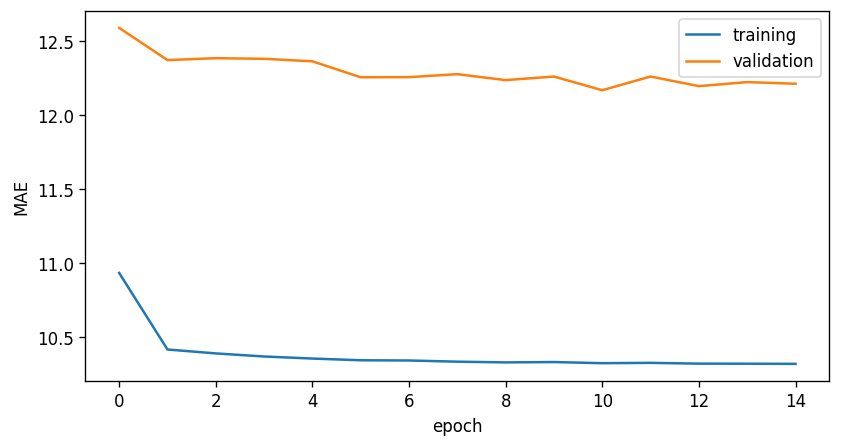

In [18]:
# plot training and validation loss 
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(history.history['mae'], label='training')
plt.plot(history.history['val_mae'], label='validation')
# plt.hlines(9.5, xmin=0, xmax=len(history.history['mae']), linestyles='dashed', color='black', linewidth=1, alpha=.75)
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [19]:
model.evaluate(tf_train)

56/56 [==============================] - 1s 6ms/step - loss: 10.5018 - mae: 10.2678 - mean_absolute_percentage_error: 2.1353


[10.501771926879883, 10.267762184143066, 2.1352570056915283]

In [20]:
ccs = model.predict(tf_valid)
valid['ccs_predicted'] = ccs

2/2 [==============================] - 0s 2ms/step


/tmp/ipykernel_128875/4139069098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['ccs_predicted'] = ccs


In [14]:
# model.save('../pretrained-models/DeepTwoMerModel/', save_format='tf')

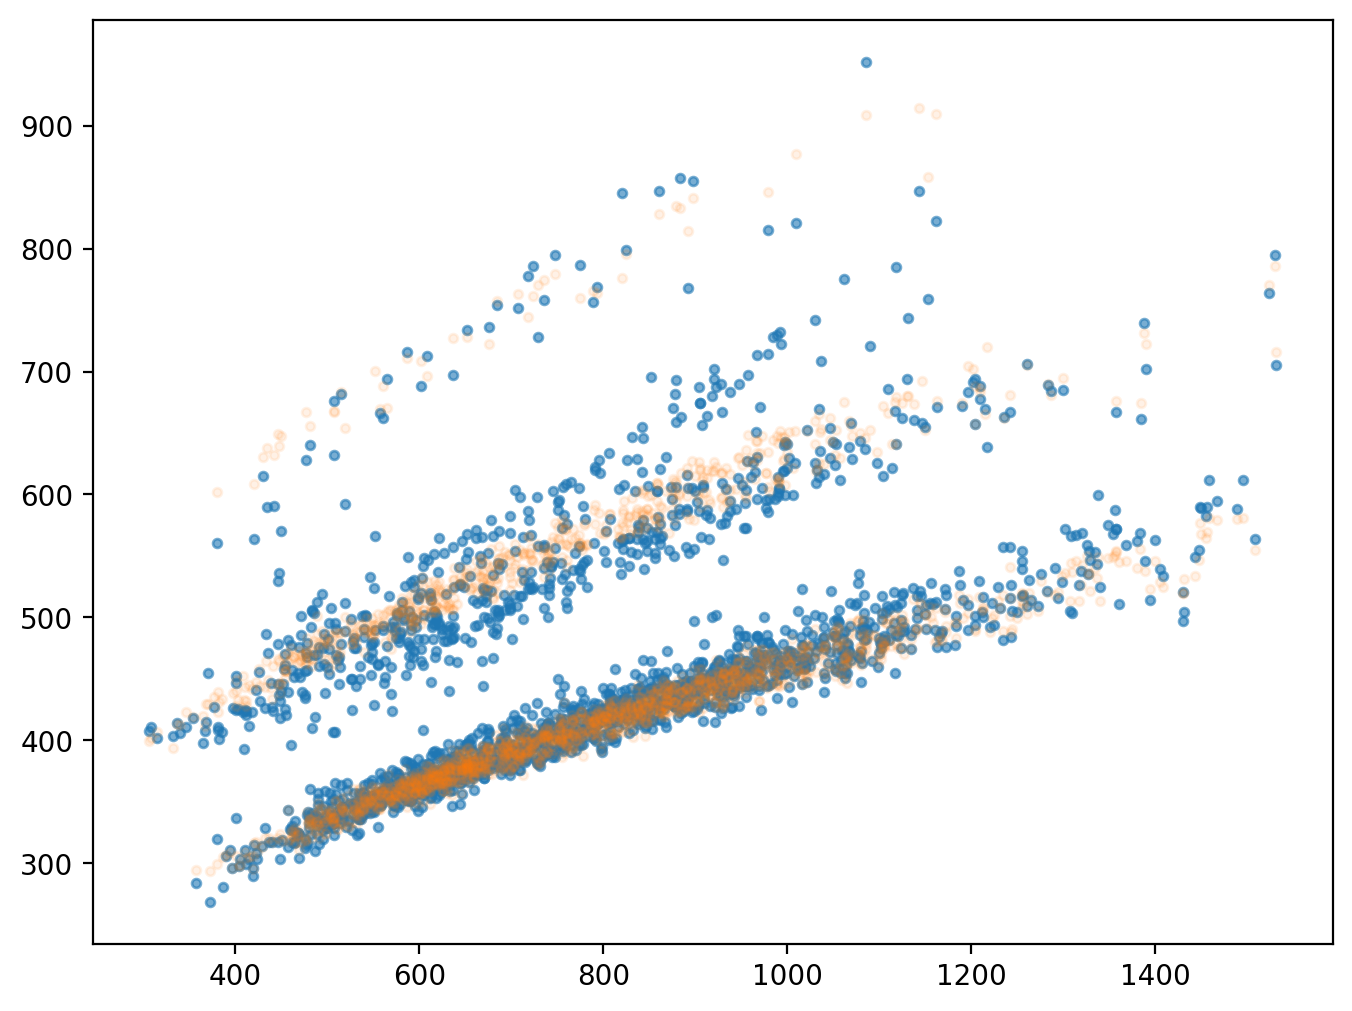

In [21]:
plt.figure(figsize=(8, 6), dpi=200)
plt.scatter(valid.mz, valid.ccs, alpha=.6, s=10)
plt.scatter(valid.mz, valid.ccs_predicted, alpha=.1, s=10)
plt.show()